Photometry
==========


Introduction
--------------

Roberto Avila has prepared some [slides](downloads/pdf_guides/phot_training_current.pdf) about photometry on Hubble images.

**You can download an executable copy of this notebook** [here](downloads/notebooks/photometry.ipynb)

This notebook will guide you through the basics of aperture photometry using [photutils](http://photutils.readthedocs.io). We will detect sources in an image, measure the signal detected from those sources in a circular aperture, remove the local background, and correct the signal for the small aperture size. At the end of this notebook, there is an exercise to create a CMD from the two HST drizzled images you created in the Drizzlepac training module. 

There are many other tools that you can use to perform photometry on HST images, including DAOPHOT, DOLPHOT, SEXTRACTOR, and EPSF. You are welcome to explore these tools, but they are beyond the scope of this training module.

This tutorial is based on the photutils documentation.


In [1]:
%matplotlib notebook
from photutils import datasets
import matplotlib.pyplot as plt
import numpy as np

Image Display
-------------
We will now display a 400 by 400 pixel region of an example image of a stellar field available through `photutils.datasets`. We scale the image logarithmically to see the stars more clearly.

<IPython.core.display.Javascript object>


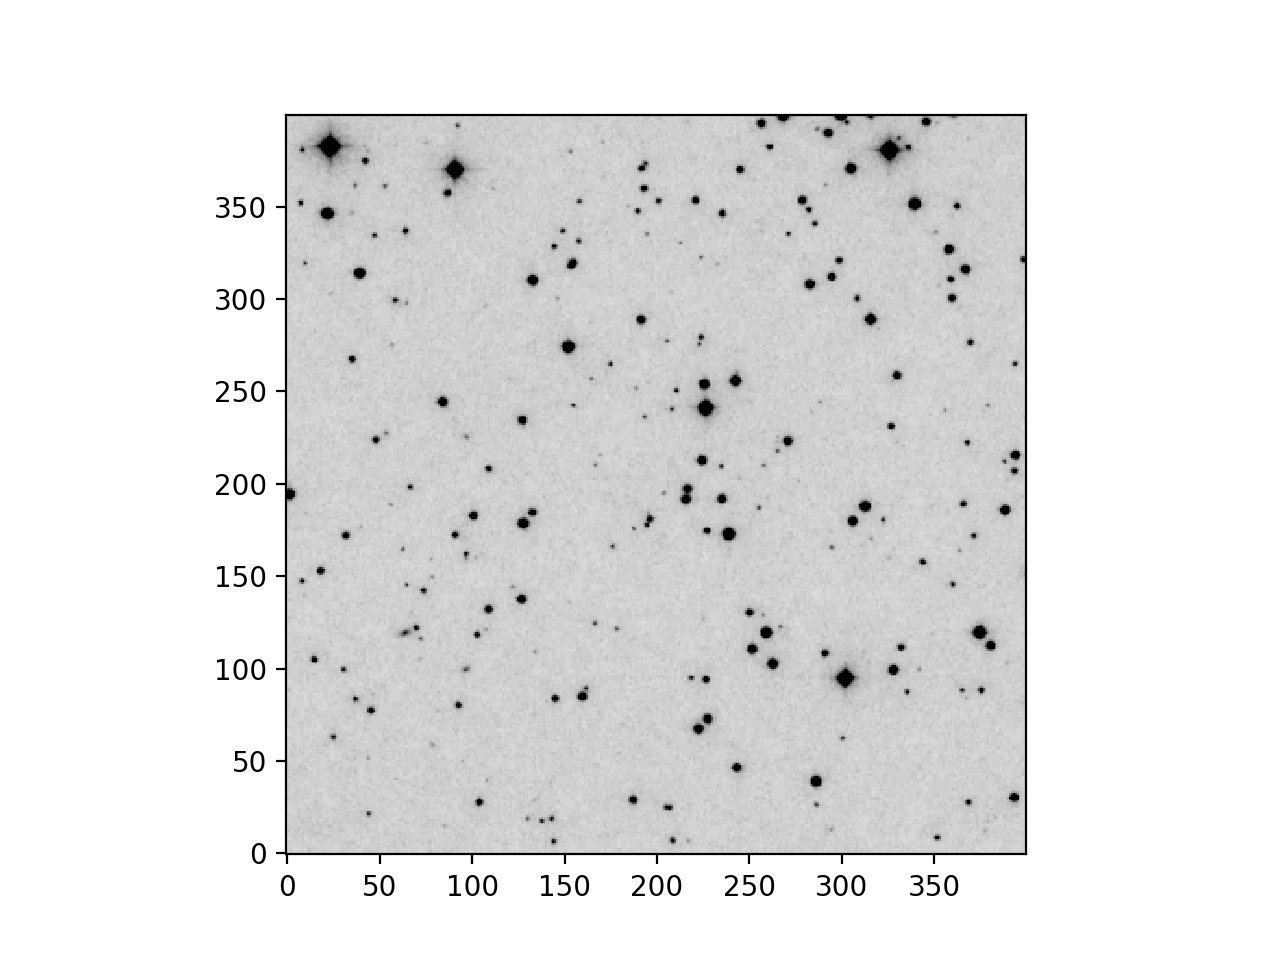

In [2]:
hdu = datasets.load_star_image()    

data = hdu.data[0:400,0:400]

plt.figure()
plt.imshow(data, cmap='Greys', origin='lower', vmin=1000, vmax=10000)

Source Detection
----------------
We need to find the stars in the image in order to perform photometry on them. If we had a pre-existing catalog of stars, we could skip this step. 

First, we measure sigma-clipped statistics of the image. This gives us the mean, median, and standard deviation of the background by clipping out the stars.

In [3]:
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder

mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
print(mean, median, std)

3667.779240018601 3649.0 204.27923665845705


We can now use `DAOStarFinder` to detect stars in the image. This algorithm detects local maxima with peaks greater than the specified threshold, which here we set to 5 times the standard devation (`$\sigma$`) of the background, calculated in the cell above. We also set the full width at half maximum (FWHM) of a Gaussian kernel to be convolved with the image. This finds the centroids of detected sources with FWHM = 3.0 pixels.

We run the `DAOFIND` algorithm on our data with the median background level subtracted. We display the result, which is an `astropy` [table](https://docs.astropy.org/en/latest/api/astropy.table.Table.html#astropy.table.Table).

In [4]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data - median)
print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 144.24756716358587 ... 5.7014303303763425   -1.889959554384849
  2  208.6690686281792 ...  6.723067304548727  -2.0689186474837555
  3  216.9261366551006 ... 1.6673746759096406  -0.5550830028638235
  4  351.6251903825918 ...  5.900925481473003   -1.927300325705523
  5  377.5199099575159 ... 1.1185620378076748 -0.12165018996937246
  6  294.2728404665307 ...  1.481937466581202  -0.4270746951883969
  7  85.21772831944668 ...  1.246529231429441  -0.2392561681898378
  8 137.94128566136274 ...  4.686393835785991  -1.6770969577295367
  9 130.32797244529527 ... 2.8660100626772897  -1.1431942772237504
 10  143.1104993046545 ...   5.75942739885503   -1.900948270242528
...                ... ...                ...                  ...
275  292.5871162673211 ...   4.64400908153339  -1.6672326508661586
276  92.37961989086214 ... 3.6343661128388383  -1.401071686060

To visualize which stars in our image were selected by `DAOFIND`, we can create a set of circular apertures to overplot on our image. 

We must first organize locations of our sources into an array of (x, y) pixel positions, e.g. `[(x1, y1), (x2, y2), (x3, y3)...]`. We can create an array with a row of x positions and a row of y positions, then use `np.transpose` to transpose the axes. The array now has the (x, y) pixel position of each star in each row.

In [5]:
loc = np.array([sources['xcentroid'], sources['ycentroid']])
print(loc.shape)

positions = np.transpose(loc)
print(positions.shape)
print(positions[:10,:])

(2, 285)
(285, 2)
[[144.24756716   6.37979043]
 [208.66906863   6.82058054]
 [216.92613666   6.57759332]
 [351.62519038   8.54590132]
 [377.51990996  12.065501  ]
 [294.27284047  12.73719125]
 [ 85.21772832  14.71034683]
 [137.94128566  17.4647184 ]
 [130.32797245  18.67808743]
 [143.1104993   18.62355307]]


<IPython.core.display.Javascript object>


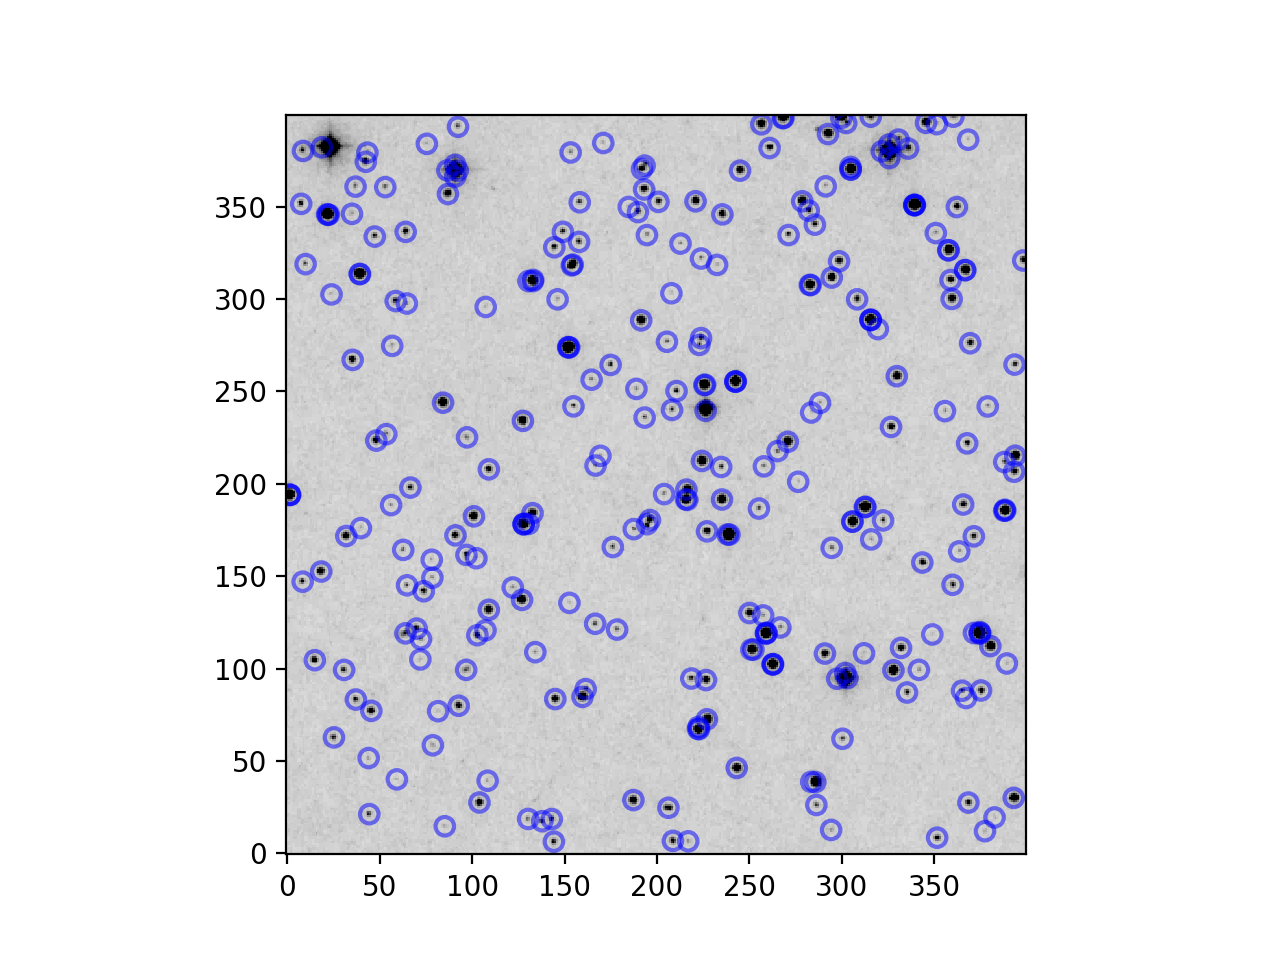

In [6]:
from photutils import CircularAperture

apertures = CircularAperture(positions, r=5.)

plt.figure()
plt.imshow(data, cmap='Greys', origin='lower', vmin=1000, vmax=10000)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

Aperture photometry
-------------------
Now that we have the positions of the stars in the image, we can proceed with measuring their fluxes. We create a set of circular apertures of radius 3 pixels, and run aperture photometry on our sources. (The apertures created in the cell above were for visualization purposes only.)

In [7]:
from photutils import aperture_photometry

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_r3 = CircularAperture(positions, r=3.)

rawflux_r3 = aperture_photometry(data, apertures_r3)
print(rawflux_r3)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 144.24756716358587  6.379790427039487 150016.28584605257
  2  208.6690686281792  6.820580537772934  166979.5259356466
  3  216.9261366551006  6.577593319804561 115993.33547389417
  4  351.6251903825918  8.545901323298796 160148.66263054474
  5  377.5199099575159 12.065500998677424 112254.53815981344
  6  294.2728404665307  12.73719125082539 118501.69362095291
  7  85.21772831944668 14.710346834511745 110464.80720831131
  8 137.94128566136274  17.46471840389003 142749.24467435555
  9 130.32797244529527 18.678087427830548 123773.18793978506
 10  143.1104993046545 18.623553071389225 153969.04351750042
...                ...                ...                ...
276  92.37961989086214  393.2493153302884 129802.00787908977
277  256.4984853337412  394.5631772116358 254674.36127923487
278  302.4110317574814  

Next, we measure a local background around each star. We create a set of annuli centered on each star with inner radii 9 pixels and outer radii 12 pixels. 

In [8]:
from photutils import CircularAnnulus

annulus_apertures = CircularAnnulus(positions, r_in=9., r_out=12.)

To ensure that we are not including bright pixels from nearby sources in the annulus around each of our stars, we calculate a sigma-clipped median of each annulus rather than simply taking the average. To do this, we create a set of masks containing 1 at the location of pixels within the annulus and 0 for pixels outside the annulus. We then loop through the masks, multiplying each by the data and selecting only pixels that are greater than zero, i.e., sit inside the annulus. We calculate a sigma-clipped median of the pixels in each annulus and save it to a new array. 

In [9]:
annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

We then add the median background level for each star to the photometry table as a new column. 

In [10]:
rawflux_r3['annulus_median'] = bkg_median
print(rawflux_r3['annulus_median'])

annulus_median
--------------
        3610.0
        3576.0
        3485.0
        3593.0
        3615.0
        3621.0
        3655.0
        3723.0
        3700.0
        3763.0
           ...
        3873.0
        3731.0
        3654.5
        3918.0
        3652.0
        3652.0
        3600.0
        3600.0
        3827.0
        3827.0
        3470.0
Length = 285 rows


We estimate the background contained in the 3 pixel aperture for each star by multiplying the median background value by the number of pixels encircled by the aperture.

In [11]:
rawflux_r3['aper_bkg'] = bkg_median*apertures_r3.area
print(rawflux_r3['aper_bkg'])

     aper_bkg     
------------------
102070.34531513238
 101109.0179631339
 98536.05357984387
101589.68163913314
102211.71698454392
102381.36298783777
103342.69033983625
 105265.3450438332
 104615.0353645401
106396.31839912552
               ...
109506.49512617942
105491.53971489167
103328.55317289509
110778.84015088329
103257.86733818932
103257.86733818932
101787.60197630929
101787.60197630929
108205.87576759324
108205.87576759324
 98111.93857160924
Length = 285 rows


Finally, we subtract the background value from the stellar flux within the 3 pixel aperture.

In [12]:
rawflux_r3['final_phot'] = rawflux_r3['aperture_sum'] - rawflux_r3['aper_bkg']
print(rawflux_r3['final_phot'])

    final_phot    
------------------
  47945.9405309202
 65870.50797251271
17457.281894050306
58558.980991411605
 10042.82117526952
 16120.33063311514
 7122.116868475059
37483.899630522355
19158.152575244952
  47572.7251183749
               ...
 146862.3642657415
  24310.4681641981
151345.80810633977
 82045.74066459255
17218.674823727706
143710.92908574024
146325.41978089508
146550.62975501476
 126797.9537367674
40679.870185882784
17988.249177691032
Length = 285 rows


Aperture corrections
--------------------
We performed our photometry with a small aperture to maximize the signal to noise of our measurement. However, the point spread function (PSF) of the camera extends beyond 3 pixels, meaning that our aperture does not encompass all of the light from each star. To compensate, we will perform photometry with a larger aperture that should contain much more (if not all) of the star's light. The difference in magnitude between the two aperture measurements is the aperture correction, and is applied to each star to add back the missing flux from the 3 pixel aperture.

We pick a radius of 5 pixels for the larger aperture. (Note that most PSFs for HST imaging modes extend beyond 5 pixels as well, so the steps shown here are for demonstrative purposes.) We can subtract the same local backgrounds from these larger apertures by using the same median backgrounds measured above and scaling to the larger aperture area.

In [13]:
apertures_r5 = CircularAperture(positions, r=5.)
rawflux_r5 = aperture_photometry(data, apertures_r5)

rawflux_r5['aper_bkg'] = rawflux_r3['annulus_median']*apertures_r5.area
rawflux_r5['final_phot'] = rawflux_r5['aperture_sum'] - rawflux_r5['aper_bkg']
print(rawflux_r5['final_phot'])
print(rawflux_r5[rawflux_r5['final_phot'] < 0]['ycenter'])

    final_phot    
------------------
 60779.46820615523
 82001.66135579185
28421.496595575125
    67390.74885628
14159.464201176888
 22653.64809241926
 6332.783711708151
 62023.13111612992
22395.927812820708
  66656.3800834394
               ...
179537.07908703992
31400.481559057138
192694.27458395716
172788.12938065385
62165.564977056696
170272.66246416944
  135954.536341372
132604.02404183295
122332.02984200773
-25318.95639984688
-43158.61401863248
Length = 285 rows
[320.86069335 398.70251891 398.69853955] pix


We can see that there are a few stars with negative fluxes in the 5-pixel aperture final photometry. These stars lie on the edge of the image, causing some of their signal to be undetected. Subtracting off the background causes the flux of the star to become negative. We will remove any stars from both the 3- and 5-pixel photometry that have negative fluxes in either table.

In [14]:
mask_negative = (rawflux_r3['final_phot'] > 0) & (rawflux_r5['final_phot'] > 0)

rawflux_pos_r3 = rawflux_r3[mask_negative]
rawflux_pos_r5 = rawflux_r5[mask_negative]

Now, we convert these fluxes into instrumental magnitudes, which do not require a zeropoint. If we wanted to put these measurements into a flux-calibrated magnitude system, we would need to find the appropriate zeropoint for the filter and units of the image. For more details and examples, you can read the zeropoints webpages for [ACS](http://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints) and [WFC3](http://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration). Because we only need to know the relative difference between the two magnitudes, no zeropoint is necessary.

In [15]:
mag_r3 = -2.5*np.log10(rawflux_pos_r3['final_phot'])
mag_r5 = -2.5*np.log10(rawflux_pos_r5['final_phot'])

deltamag = mag_r3 - mag_r5
print(deltamag)

      final_phot     
---------------------
  0.25751263373451216
  0.23782909673577457
   0.5291757952689959
  0.15251692890860902
  0.37297772550287434
  0.36941051176630424
 -0.12753610084808464
   0.5467723016203436
  0.16953857835848574
   0.3662092369117662
                  ...
   1.1741038545441196
  -1.2574231008925665
  0.21810909971442527
   0.2778574650912322
    0.262246035733229
   0.8086446575148933
   1.3938754014201997
  0.18413782456521055
  -0.0798151890040586
 -0.10857746380317757
-0.038930157426218415
Length = 282 rows


Let's plot the aperture corrections, `deltamag`, as a function of the 5-pixel instrumental magnitudes.

<IPython.core.display.Javascript object>


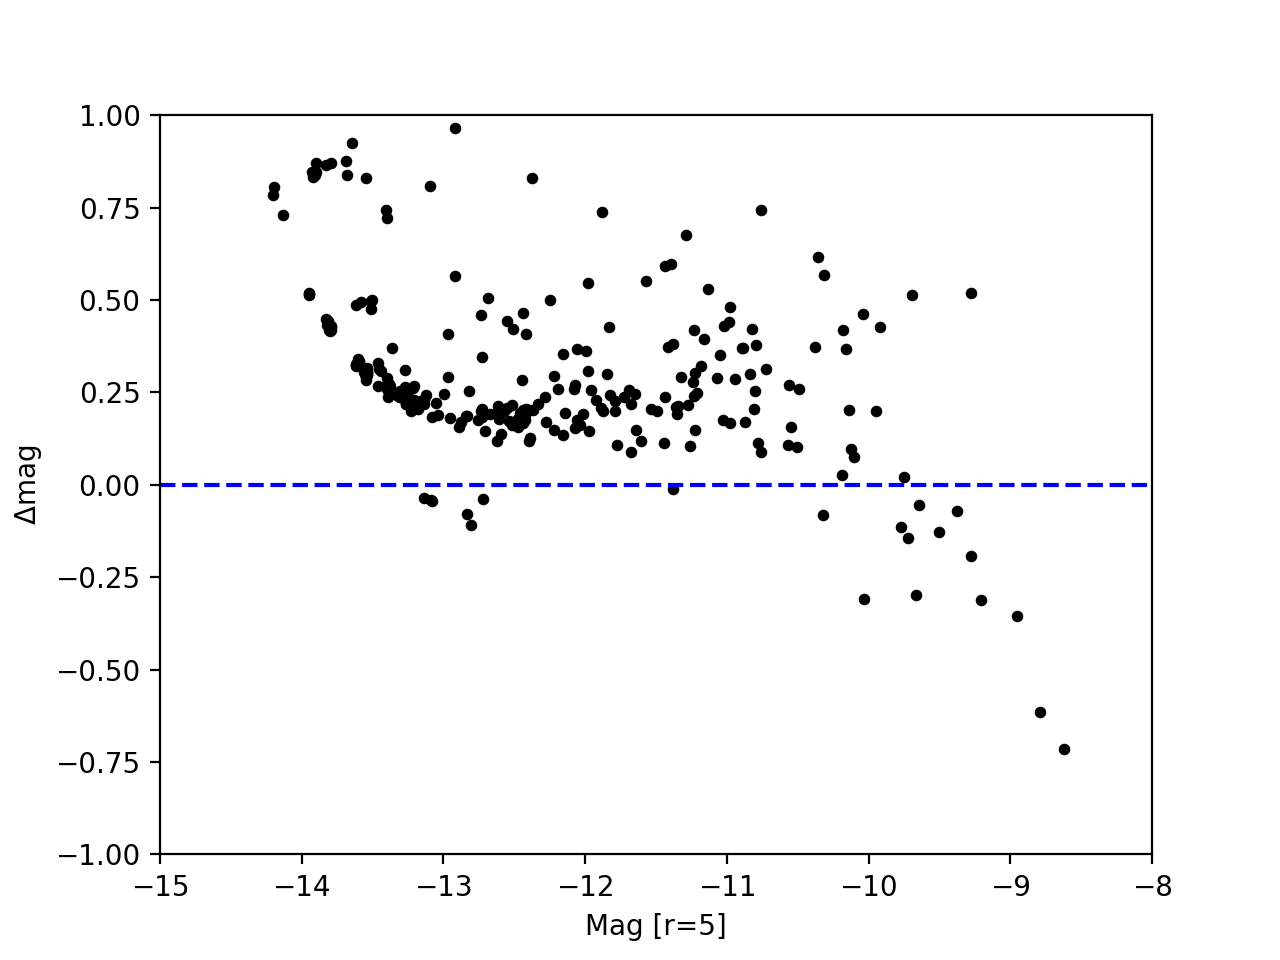

Text(0, 0.5, '$\\Delta$mag')

In [16]:
plt.figure()
plt.scatter(mag_r5, deltamag, c='k', s=10)
plt.axhline(ls='--', c='b')
plt.xlim(-15,-8)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

There is a lot of scatter in this plot. The left end is dominated by very bright, possibly saturated, stars. The right end is very dim stars. Both should be ignored from our estimate of the aperture correction. There appears to be an overdensity around `deltamag = 0.15`, so we will use stars in that region to calculate the aperture correction.

We calculate the sigma-clipped median aperture correction, and overplot it on the region of interest from the plot above.

0.20244459731092057


<IPython.core.display.Javascript object>


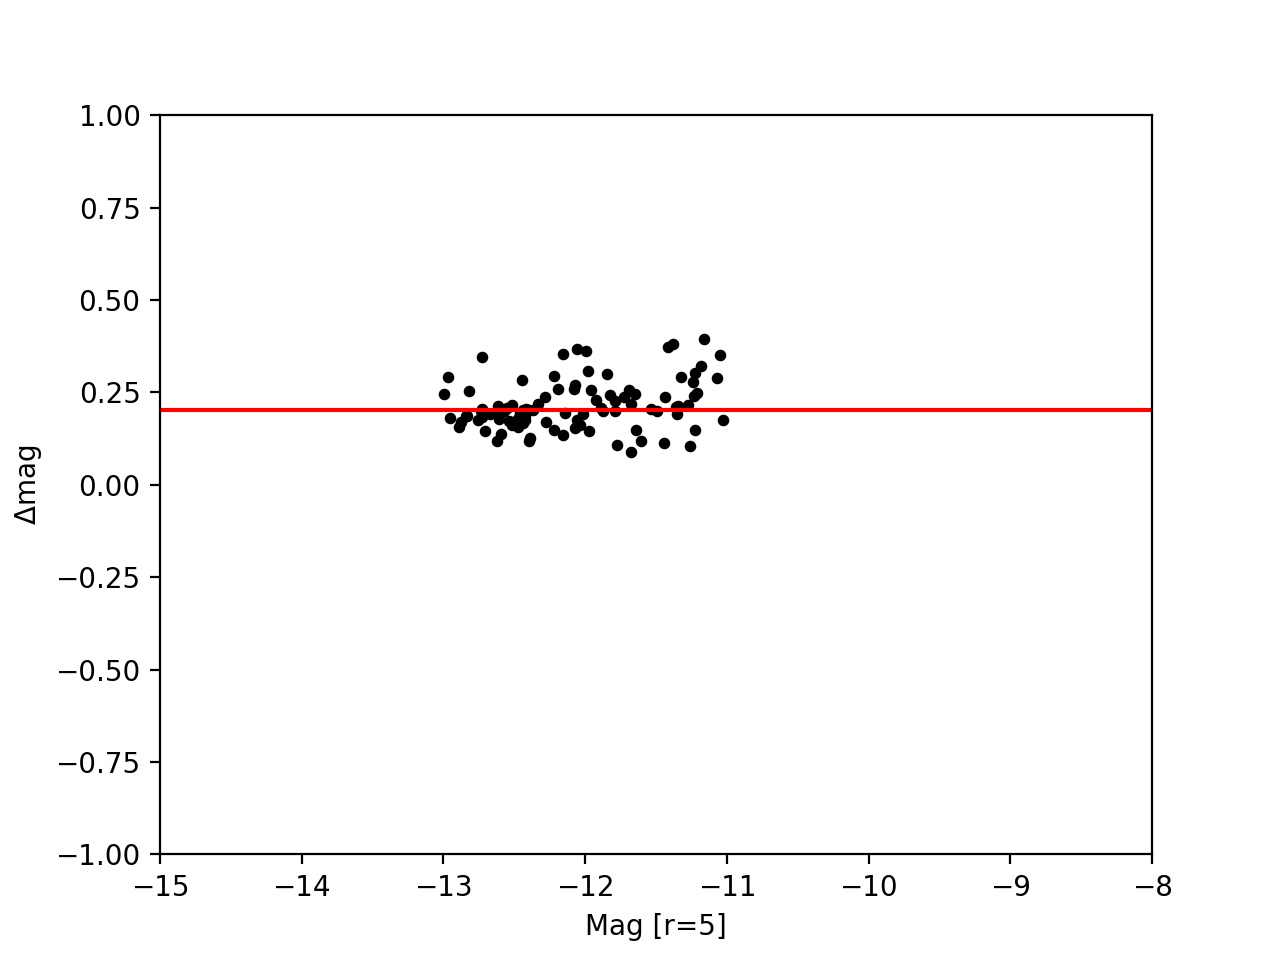

Text(0, 0.5, '$\\Delta$mag')

In [17]:
mask = (mag_r5 > -13.) & (mag_r5 < -11.) & (deltamag > 0.) & (deltamag < 0.4)

mean, median, std = sigma_clipped_stats(deltamag[mask], sigma=3.0, maxiters=5)
apcor = median
print(apcor)

plt.figure()
plt.scatter(mag_r5[mask], deltamag[mask], c='k', s=10)
plt.axhline(apcor,ls='-',c='r')
plt.xlim(-15,-8)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

We can now calculate the final 3-pixel aperture magnitudes. Note that we subtract the median aperture correction from the instrumental magnitudes because the stars should be brighter than measured in a 3 pixel aperture. This translates to a _decrease_ of the magnitude. We apply an arbitrary zeropoint of 25.0, which is similar to most HST broadband zeropoints.  

In [18]:
final_phot = -2.5*np.log10(rawflux_pos_r3['final_phot']) - apcor + 25.
print(final_phot)

    final_phot    
------------------
13.095675796740593
 12.75082787119898
14.192613840678339
12.878571625735091
14.792916078648476
14.279120539992691
15.166032663098969
 13.36294348690972
14.091671333559782
13.104160327903534
               ...
13.269290935612839
15.900253993004808
11.880279114130039
13.833072096575176
11.847629411170468
12.512415302832348
14.207556091644173
11.903830909960623
11.884255955940263
11.882586180134721
 12.03977479027592
Length = 282 rows


Exercise
--------

Use the images you made in the Drizzlepac training module to make a color magnitude diagram (CMD) of the stars in NGC6791. The CMD will show the F814W magnitudes as a function of the F606W - F814W color. The steps you need to take are:

1. Convert the drizzled images back to counts. 
2. Find sources on one image and use the catalog to perform photometry on both images.
3. Calculate aperture corrections and apply them to your photometry.
4. Plot CMD. Remember that the y-axis should go from bright stars at the top to dim stars at the bottom.

Below are some equations that might be helpful:

\begin{equation}
\mathrm{rescale} = 0.03/0.05 \\
\mathrm{counts\_image} = \mathrm{cps\_image} \times \mathrm{EXPTIME} + \frac{\Sigma{\mathrm{MDRIZSKY}}}{2} \times \mathrm{rescale}^2
\end{equation}

Some of these variables can be found in the drizzled image headers and in the fits table in the last extension of the drizzled images.

Below are a few cells to get you started.

In [ ]:
from astropy.io import fits

image = 'F606W_final_drc.fits'
fits.info(image)

hdu = fits.open(image)
sci = hdu[1].data
hdr = hdu[0].header
tab = hdu[4].data
hdu.close()

In [ ]:
tab['mdrizsky']

In [ ]:
(0.03/0.05)**2*np.sum(tab['mdrizsky'])/2

In [ ]:
temp_sci = sci*hdr['texptime'] + (0.03/0.05)**2*np.sum(tab['mdrizsky'])/2

In [ ]:
fits.writeto('F606W_cts.fits', temp_sci, header=hdr)